In [90]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
plt.style.use('seaborn-darkgrid')

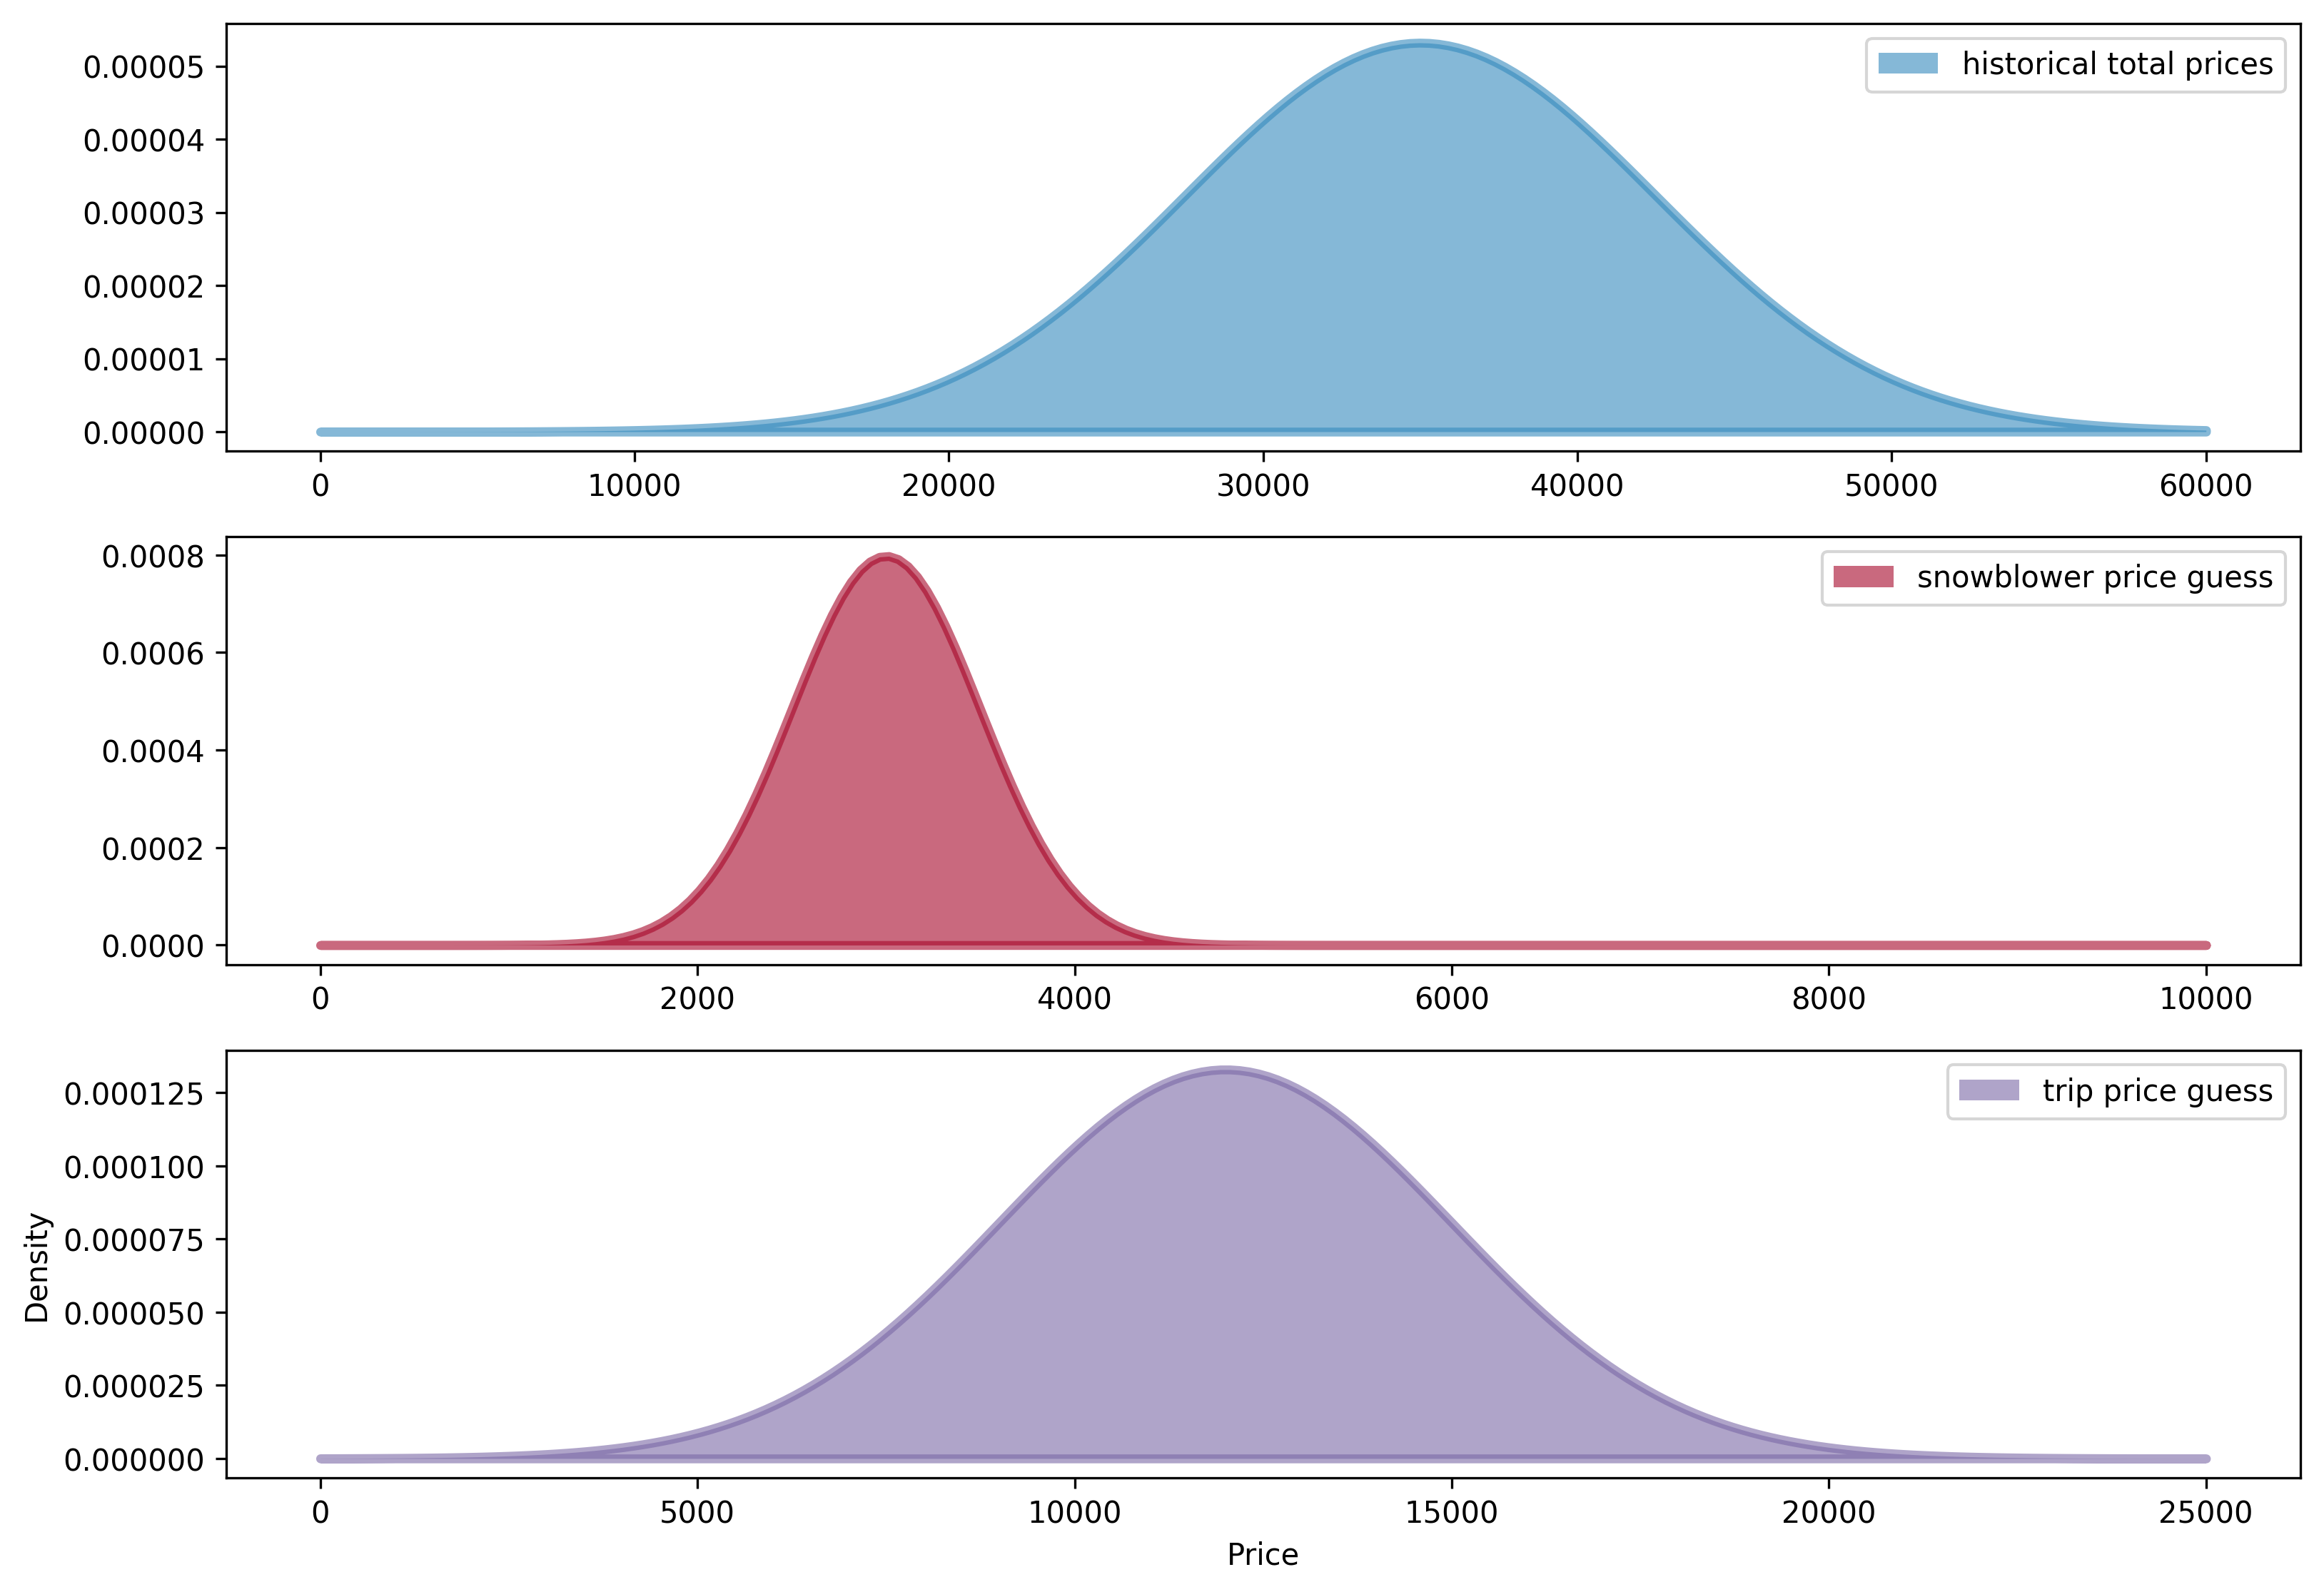

In [18]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), 
                       color='#348ABD', lw=3, alpha=0.6, label='historical total prices')
p1= plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                      color='#A60628', lw=3, alpha=0.6, label='snowblower price guess')
p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                      color='#7A68A6', lw=3, alpha=0.6, label='trip price guess')
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

plt.xlabel('Price')
plt.ylabel('Density')

In [47]:
import pymc3 as pm

data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]

mu_prior = 35e3
std_prior = 75e2

with pm.Model() as model:
    true_price = pm.Normal('true_price', mu_prior, std_prior)

    prize_1 = pm.Normal('first_prize', data_mu[0], data_std[0])
    prize_2 = pm.Normal('second_prize', data_mu[1], data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential('error', logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
    
price_trace = burned_trace['true_price']

Sampling 2 chains: 100%|██████████| 101000/101000 [00:26<00:00, 3816.93draws/s]


Potential is difficult to understand, find some other tutorials on the applications of loss functions in PyMC3

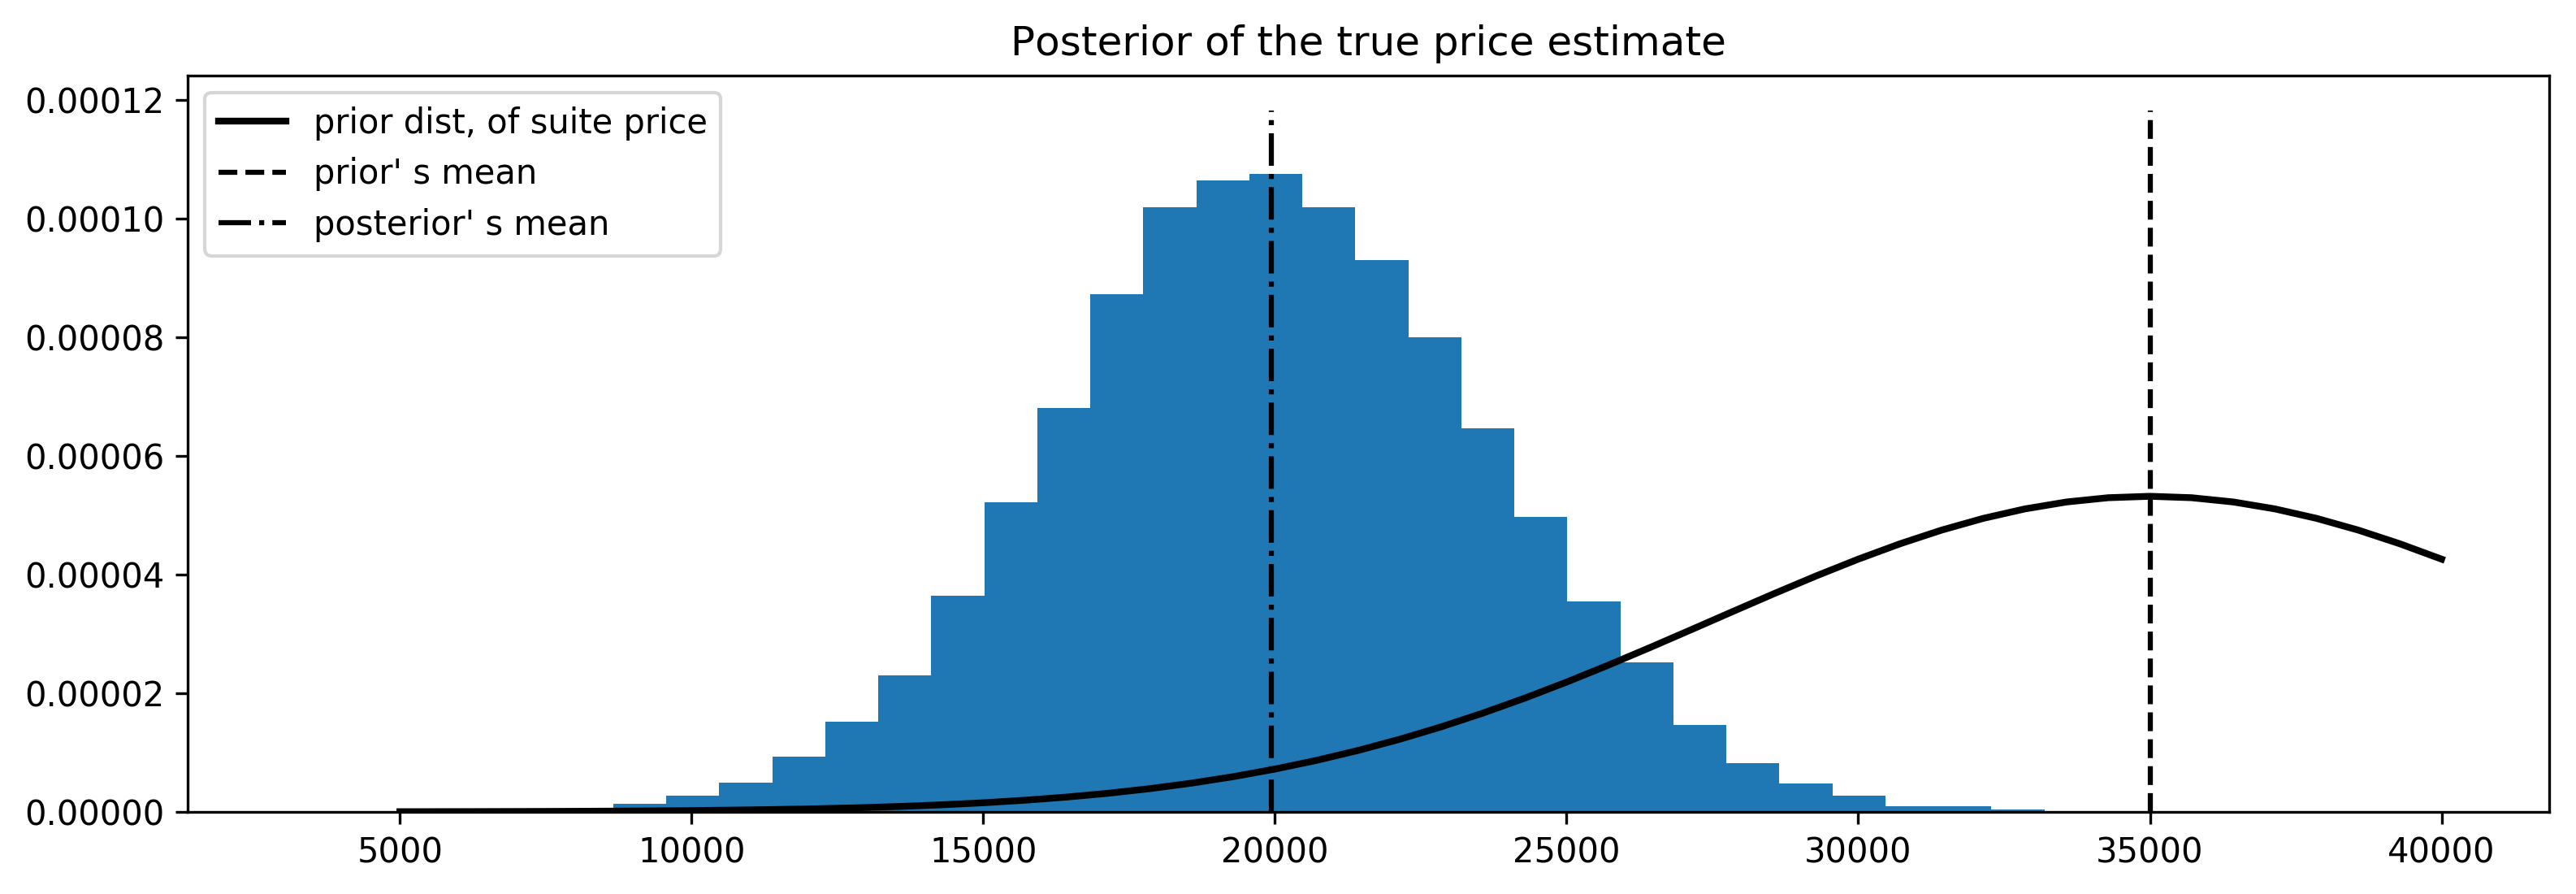

In [51]:
figsize(12.5, 4)

x = np.linspace(5000, 40000)
plt.plot(x, norm_pdf(x, 35000, 7500), c='k', lw=2, label='prior dist, of suite price')

_hist = plt.hist(price_trace, bins=35, normed=True, histtype='stepfilled')
plt.title('Posterior of the true price estimate')
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior' s mean", linestyles='--')
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label="posterior' s mean", linestyles='-.')
plt.legend(loc='upper left')

(5000, 30000)

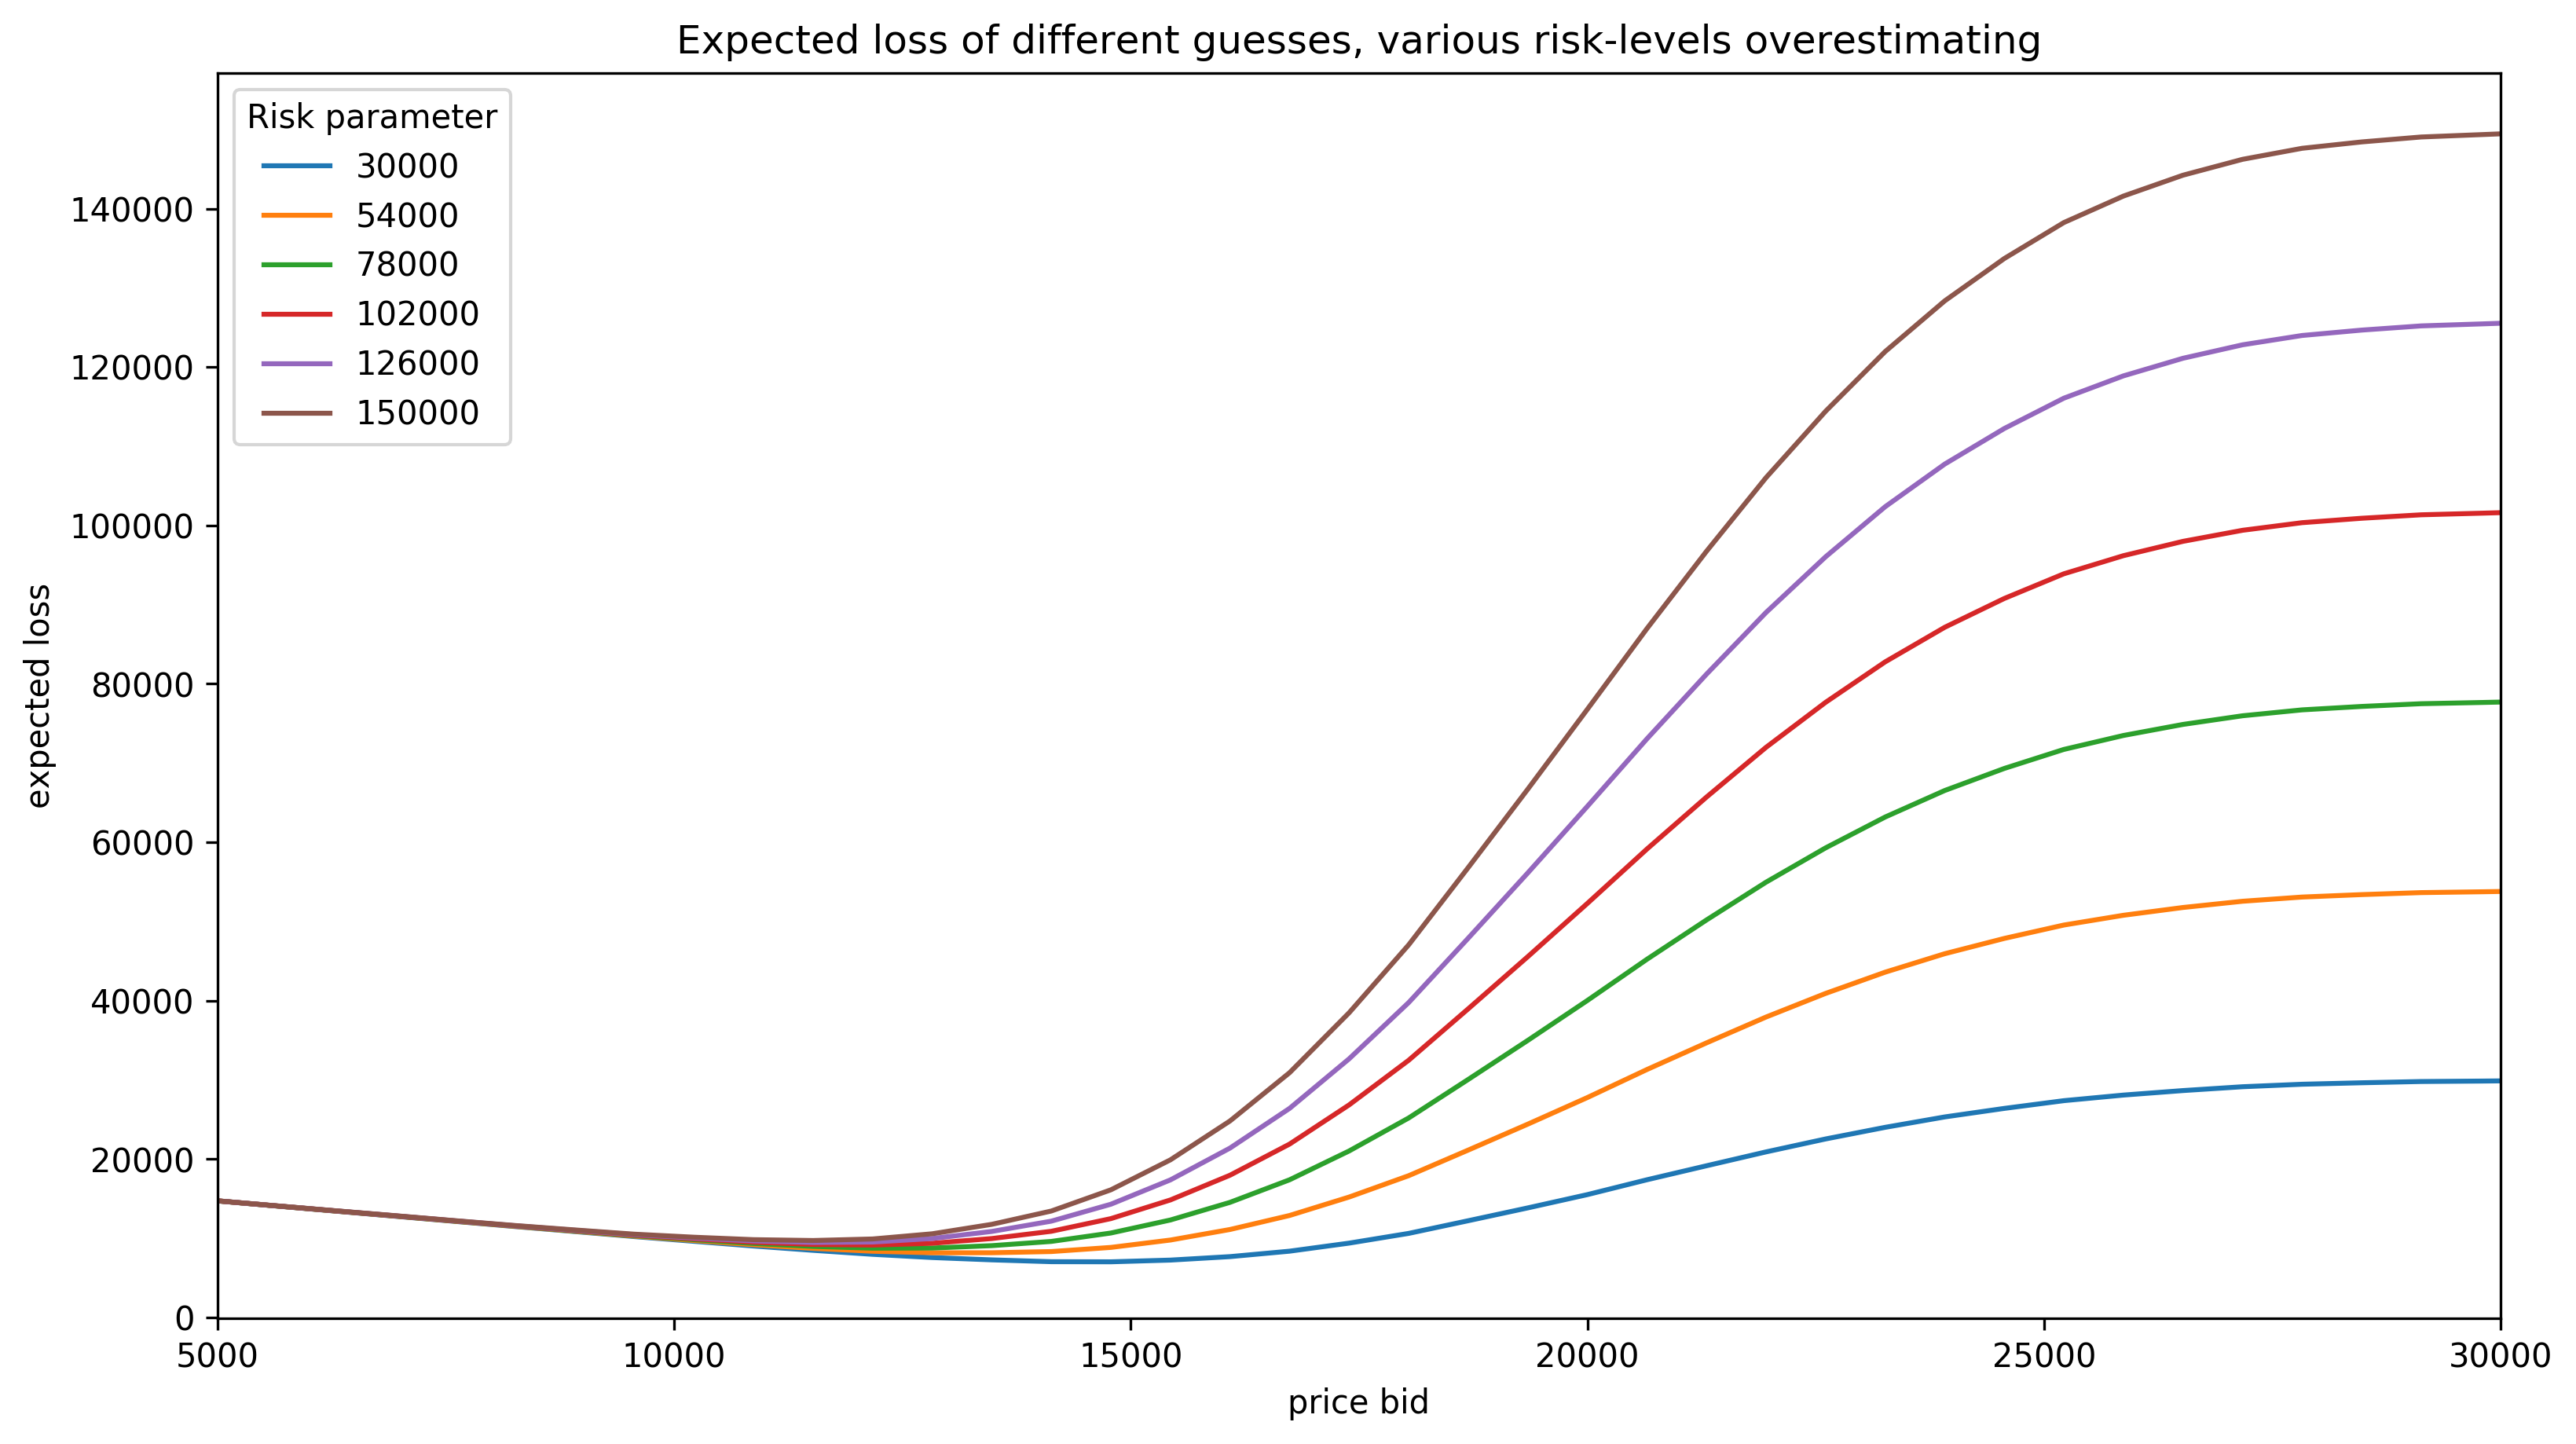

In [77]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    #print(true_price.shape)
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(true_price[~ix] - guess - 250)
    close_mask = abs(true_price - guess) <= 250
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] = risk
    
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)

expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label='%d'%_p)

plt.title('Expected loss of different guesses, various risk-levels overestimating')
plt.legend(loc='upper left', title='Risk parameter')
plt.xlabel('price bid')
plt.ylabel('expected loss')
plt.xlim(5000, 30000)

### Minimizing our losses

minimum at risk 30000: 14819.34
minimum at risk 54000: 13008.25
minimum at risk 78000: 12695.88
minimum at risk 102000: 11838.16
minimum at risk 126000: 11765.94
minimum at risk 150000: 11506.41


(-1000, 80000)

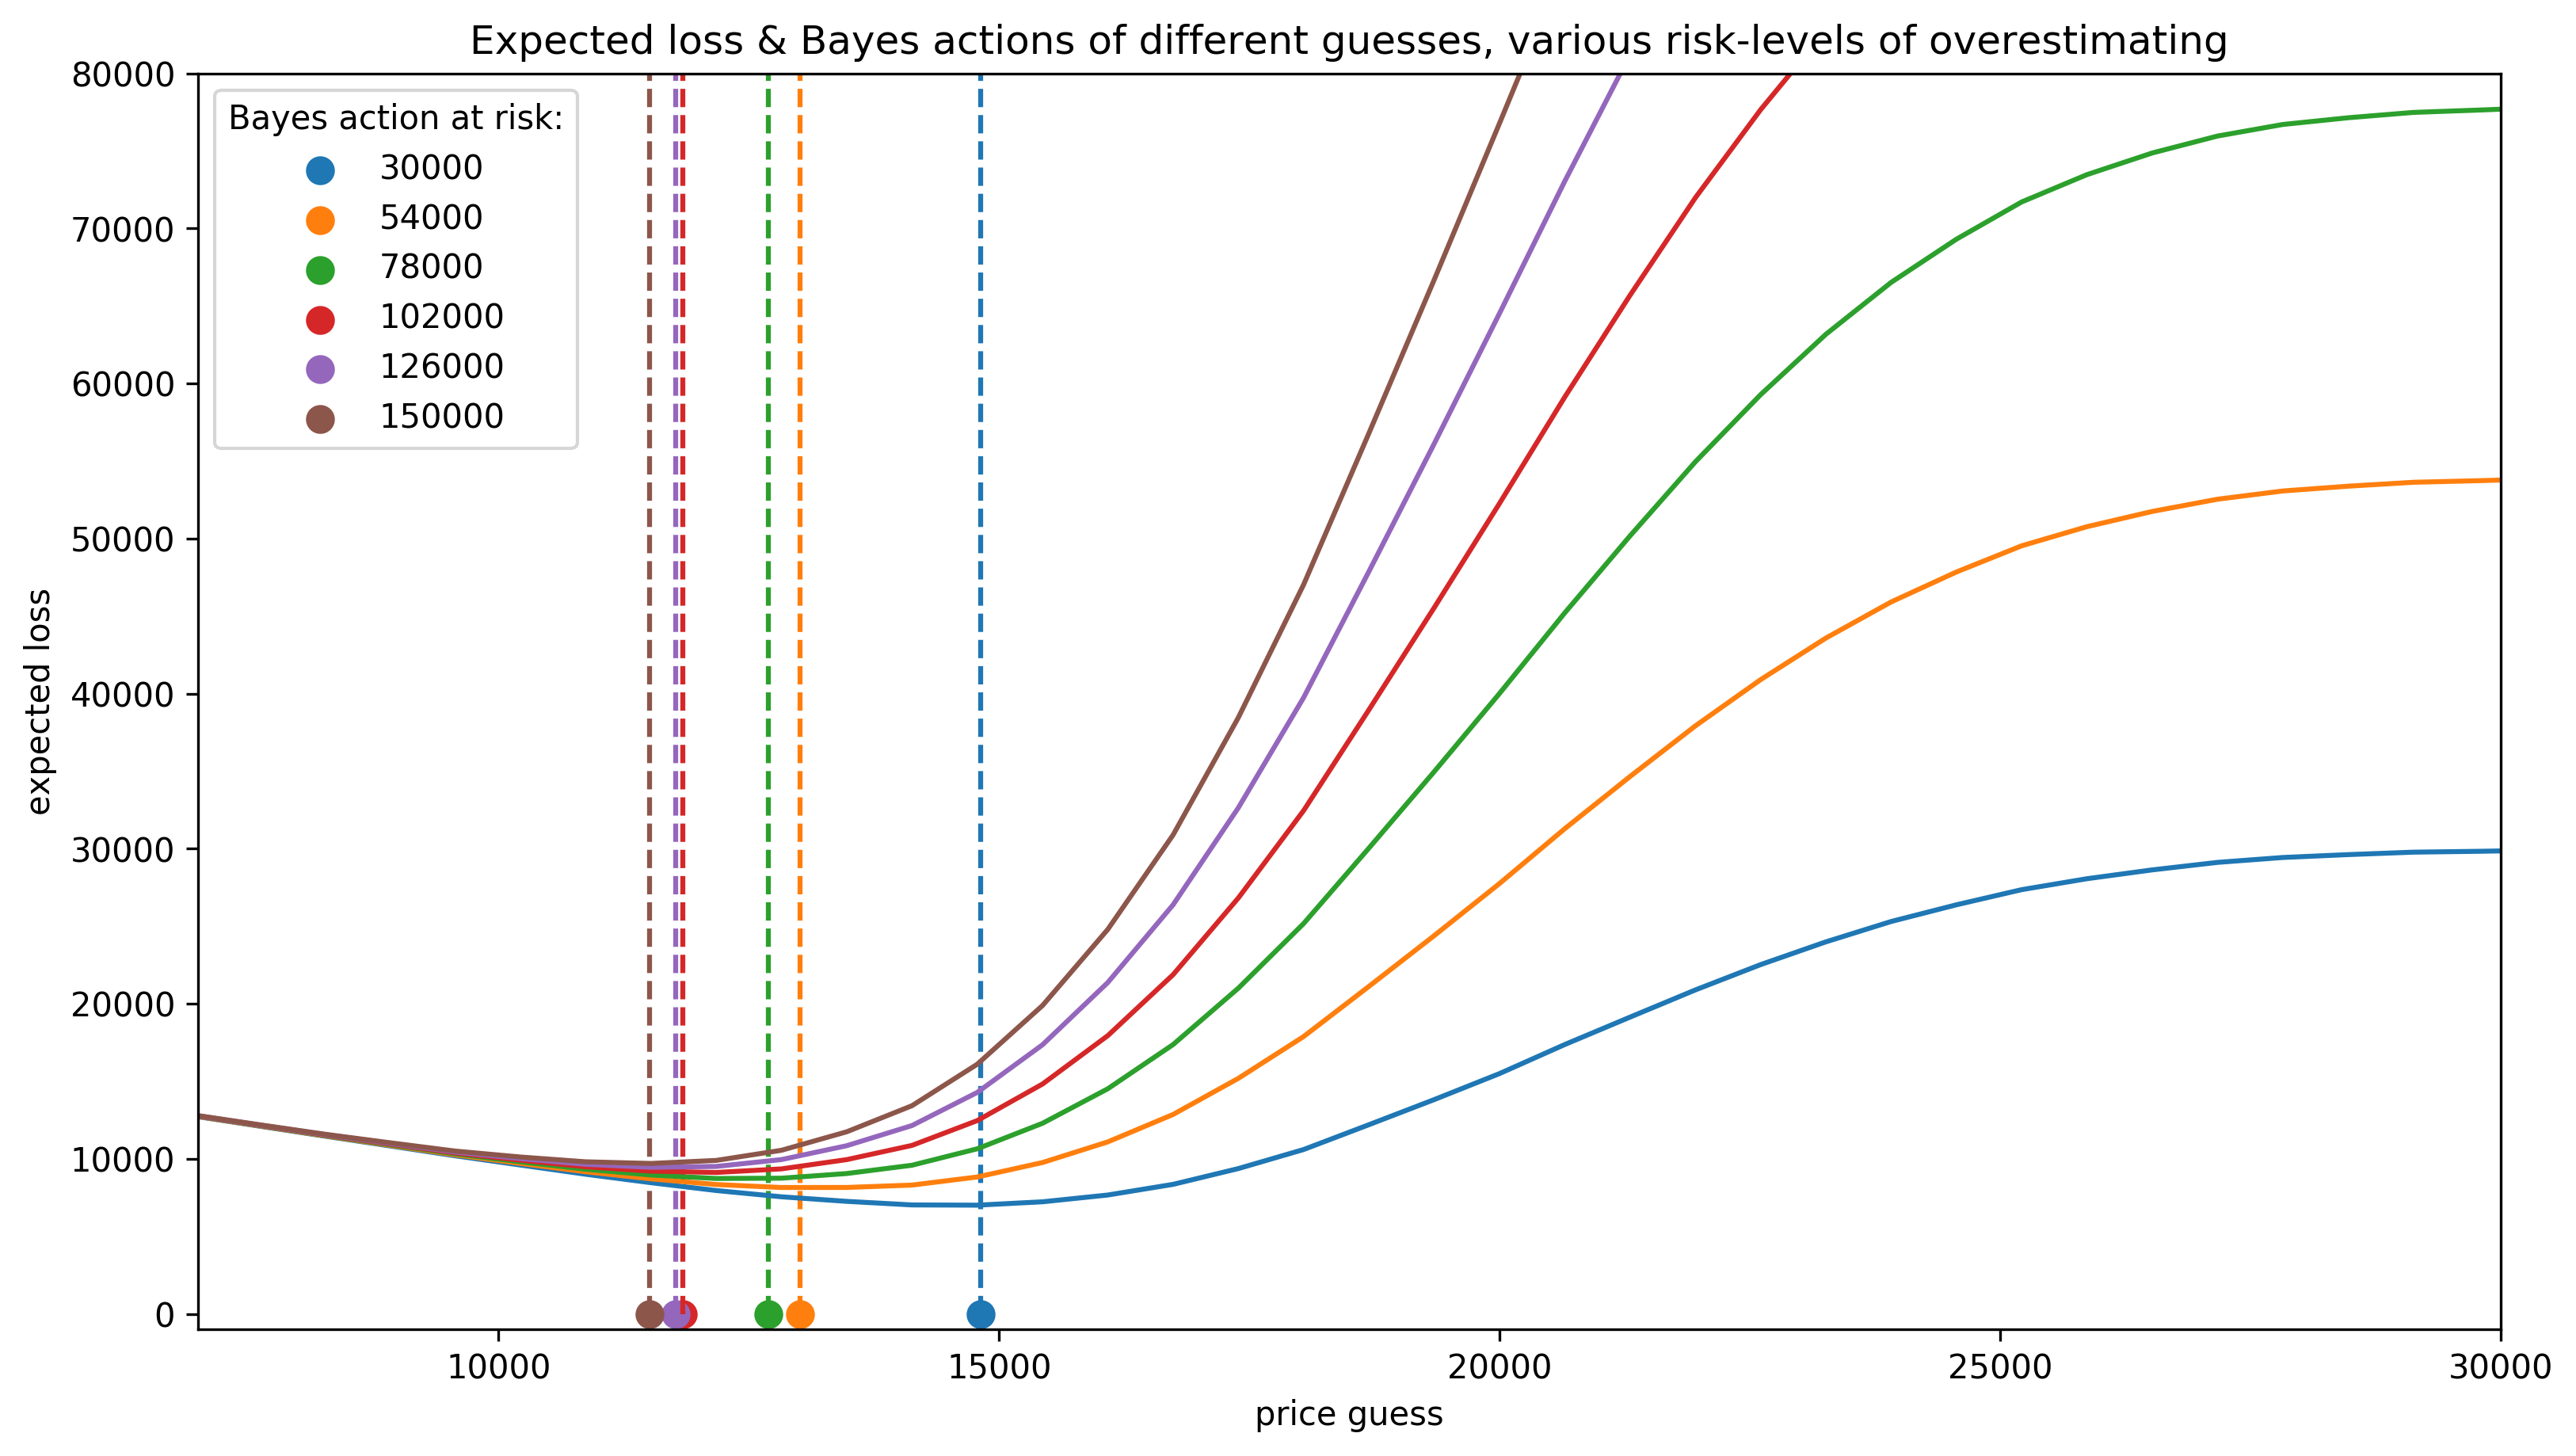

In [87]:
import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label='%d'%_p)
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles='--')
    print('minimum at risk %d: %.2f' % (_p, _min_results))

plt.title('Expected loss & Bayes actions of different guesses, various risk-levels of overestimating')
plt.legend(loc='upper left', scatterpoints=1, title='Bayes action at risk:')
plt.xlabel('price guess')
plt.ylabel('expected loss')
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)

### Machine learning via Bayesian methods
- Financial prediction

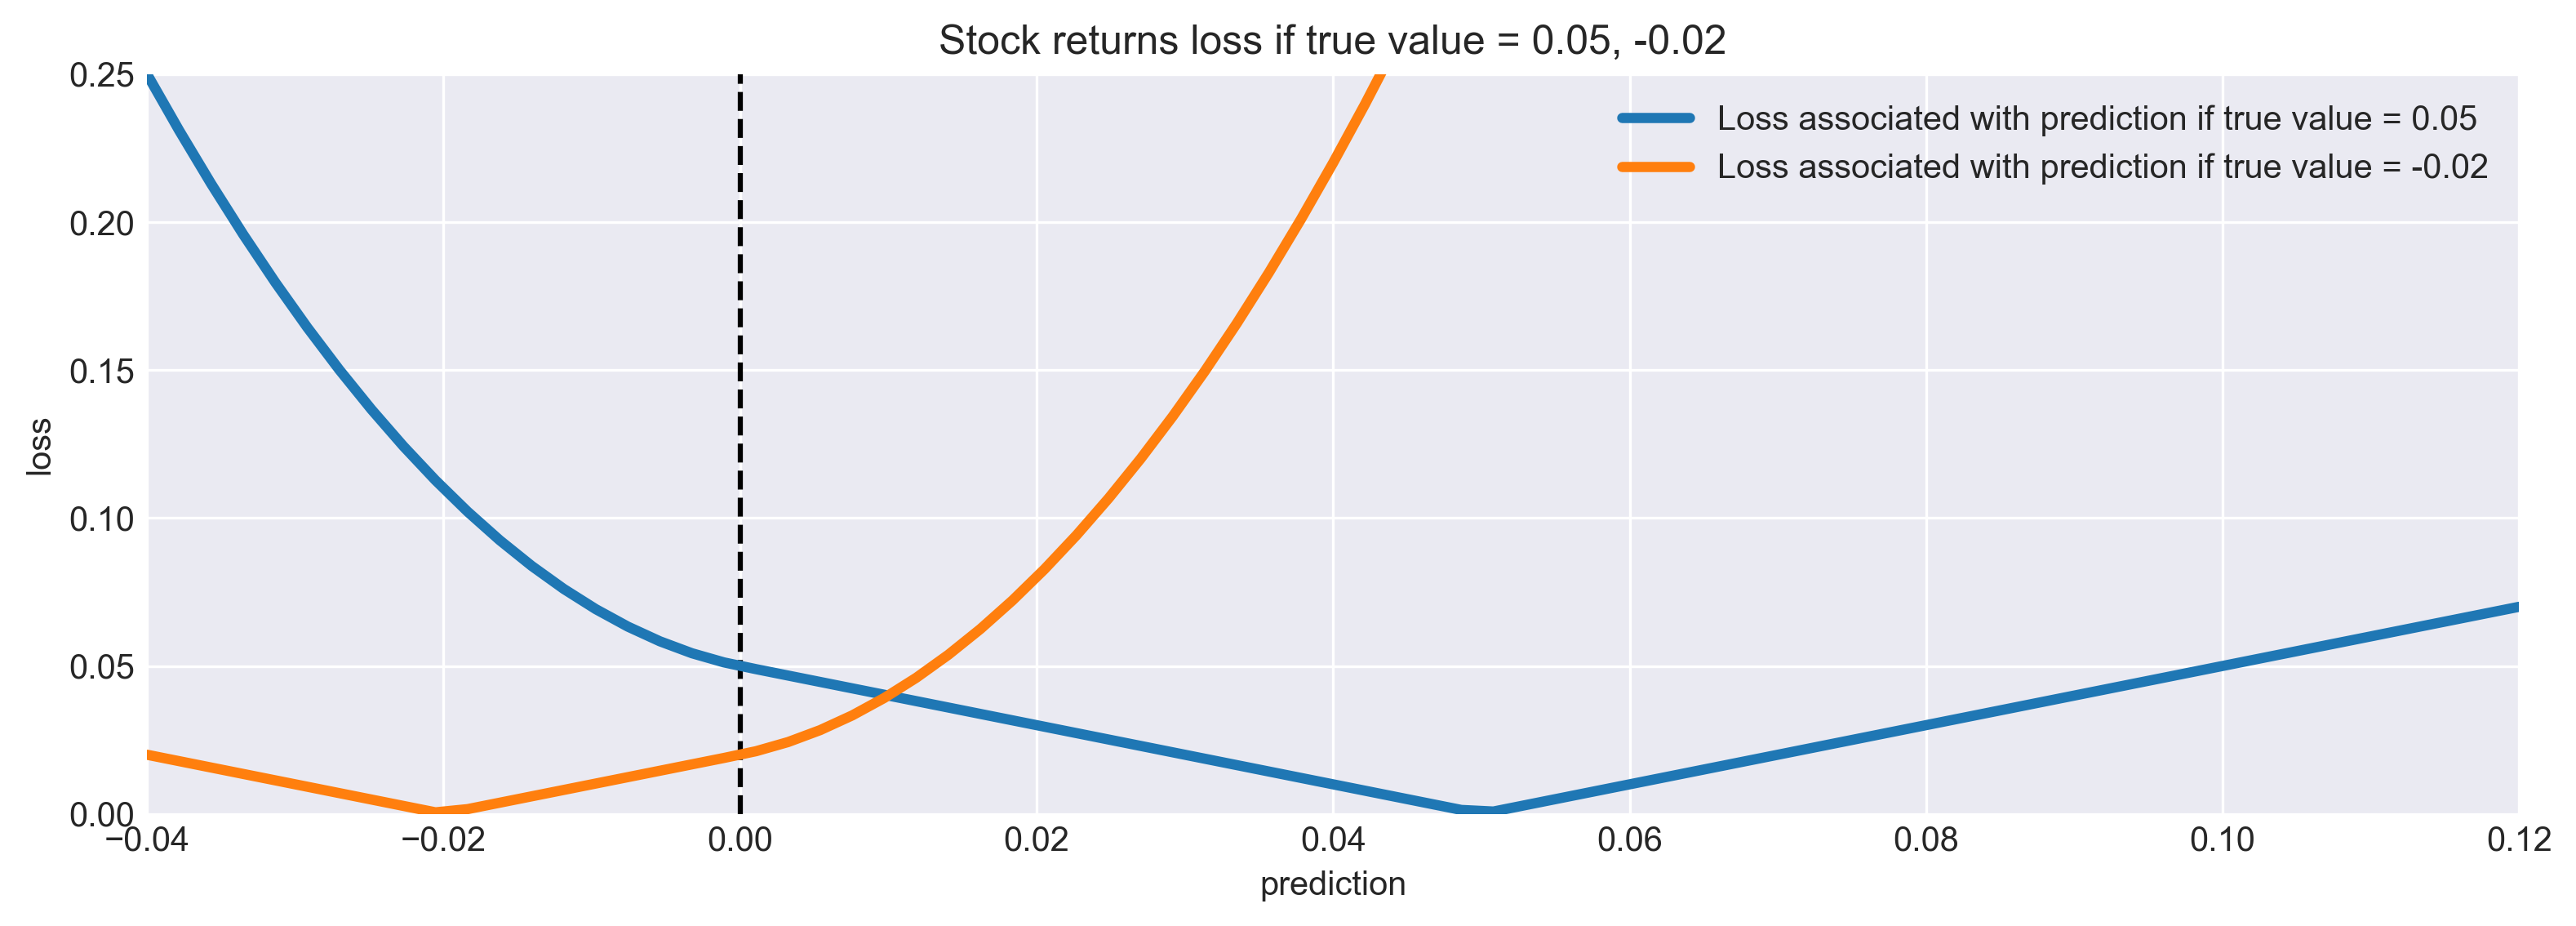

In [99]:
figsize(12.5, 4)

def stock_loss(true_return, yhat, alpha=100):
    if true_return * yhat < 0:
        return alpha * yhat ** 2 - np.sign(true_return) * yhat + abs(true_return)
    else:
        return abs(true_return - yhat)
    
true_value = .05
pred = np.linspace(-.04, .12, 75)
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], 
         label='Loss associated with prediction if true value = 0.05', lw=3)
plt.vlines(0, 0, 0.25, linestyles='--')

plt.xlabel('prediction')
plt.ylabel('loss')
plt.xlim(-.04, .12)
plt.ylim(0, .25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], 
         label='Loss associated with prediction if true value = -0.02', lw=3)

plt.title('Stock returns loss if true value = 0.05, -0.02')
plt.legend()

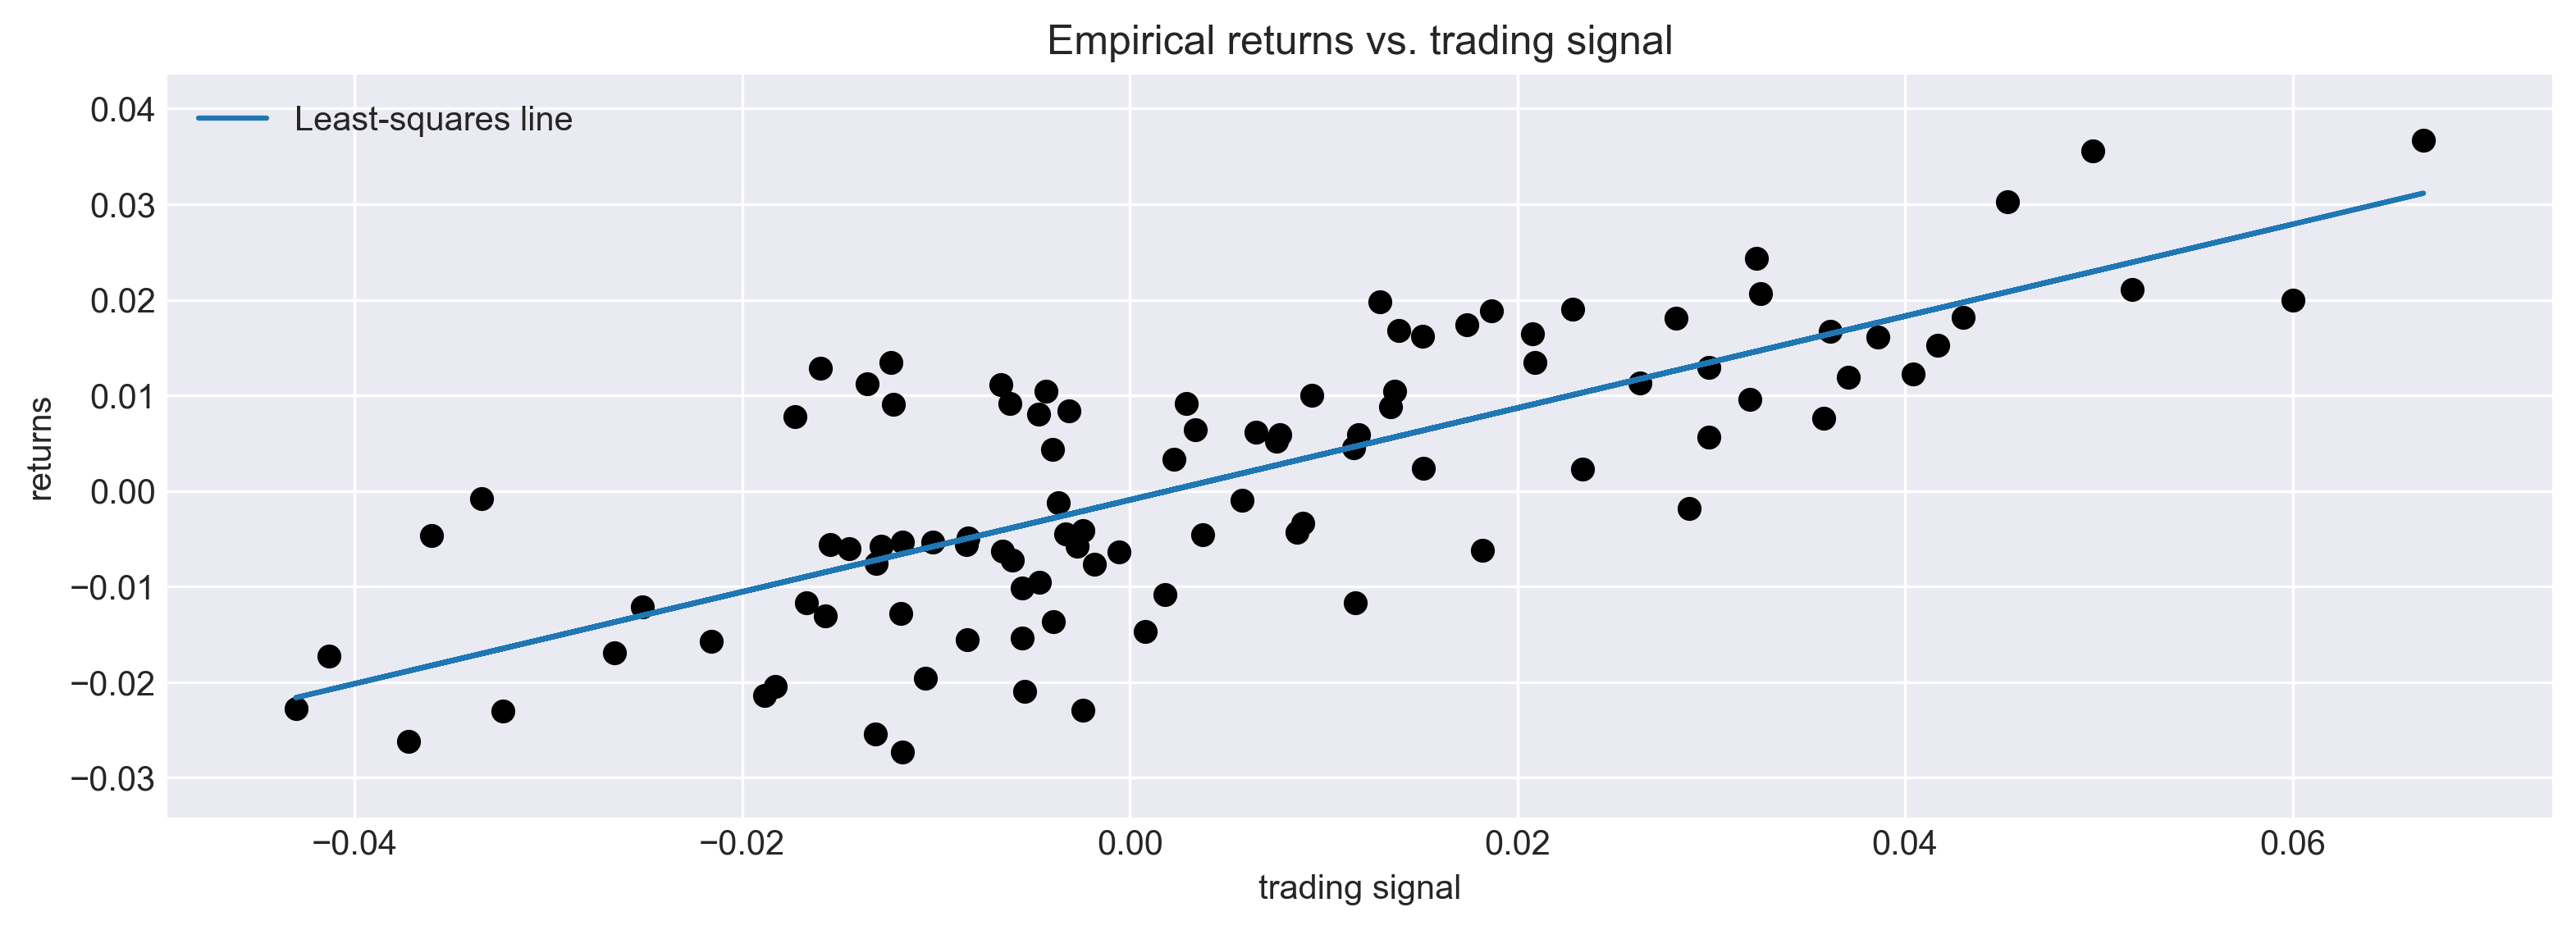

In [108]:
# artificial data
N = 100
X = .025 * np.random.randn(N)
Y = .5 * X +  .01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X, Y, c='k')
plt.xlabel('trading signal')
plt.ylabel('returns')
plt.title('Empirical returns vs. trading signal')
plt.plot(X, ls_coef_ * X + ls_intercept, label='Least-squares line')

plt.legend()

- Perform a Bayesian linear regression on this dataset.

In [123]:
with pm.Model() as model:
    std = pm.Uniform('std', 0, 100)
    
    beta = pm.Normal('beta', mu=0, sd=100)
    alpha = pm.Normal('alpha', mu=0, sd=100)
    
    mean = pm.Deterministic('mean', alpha + beta * X)
    
    obs = pm.Normal('obs', mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis(), chains=1)
    burned_trace = trace[20000:]

100%|██████████| 100500/100500 [00:36<00:00, 2743.55it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4a34b3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c4b98ce80>]], dtype=object)

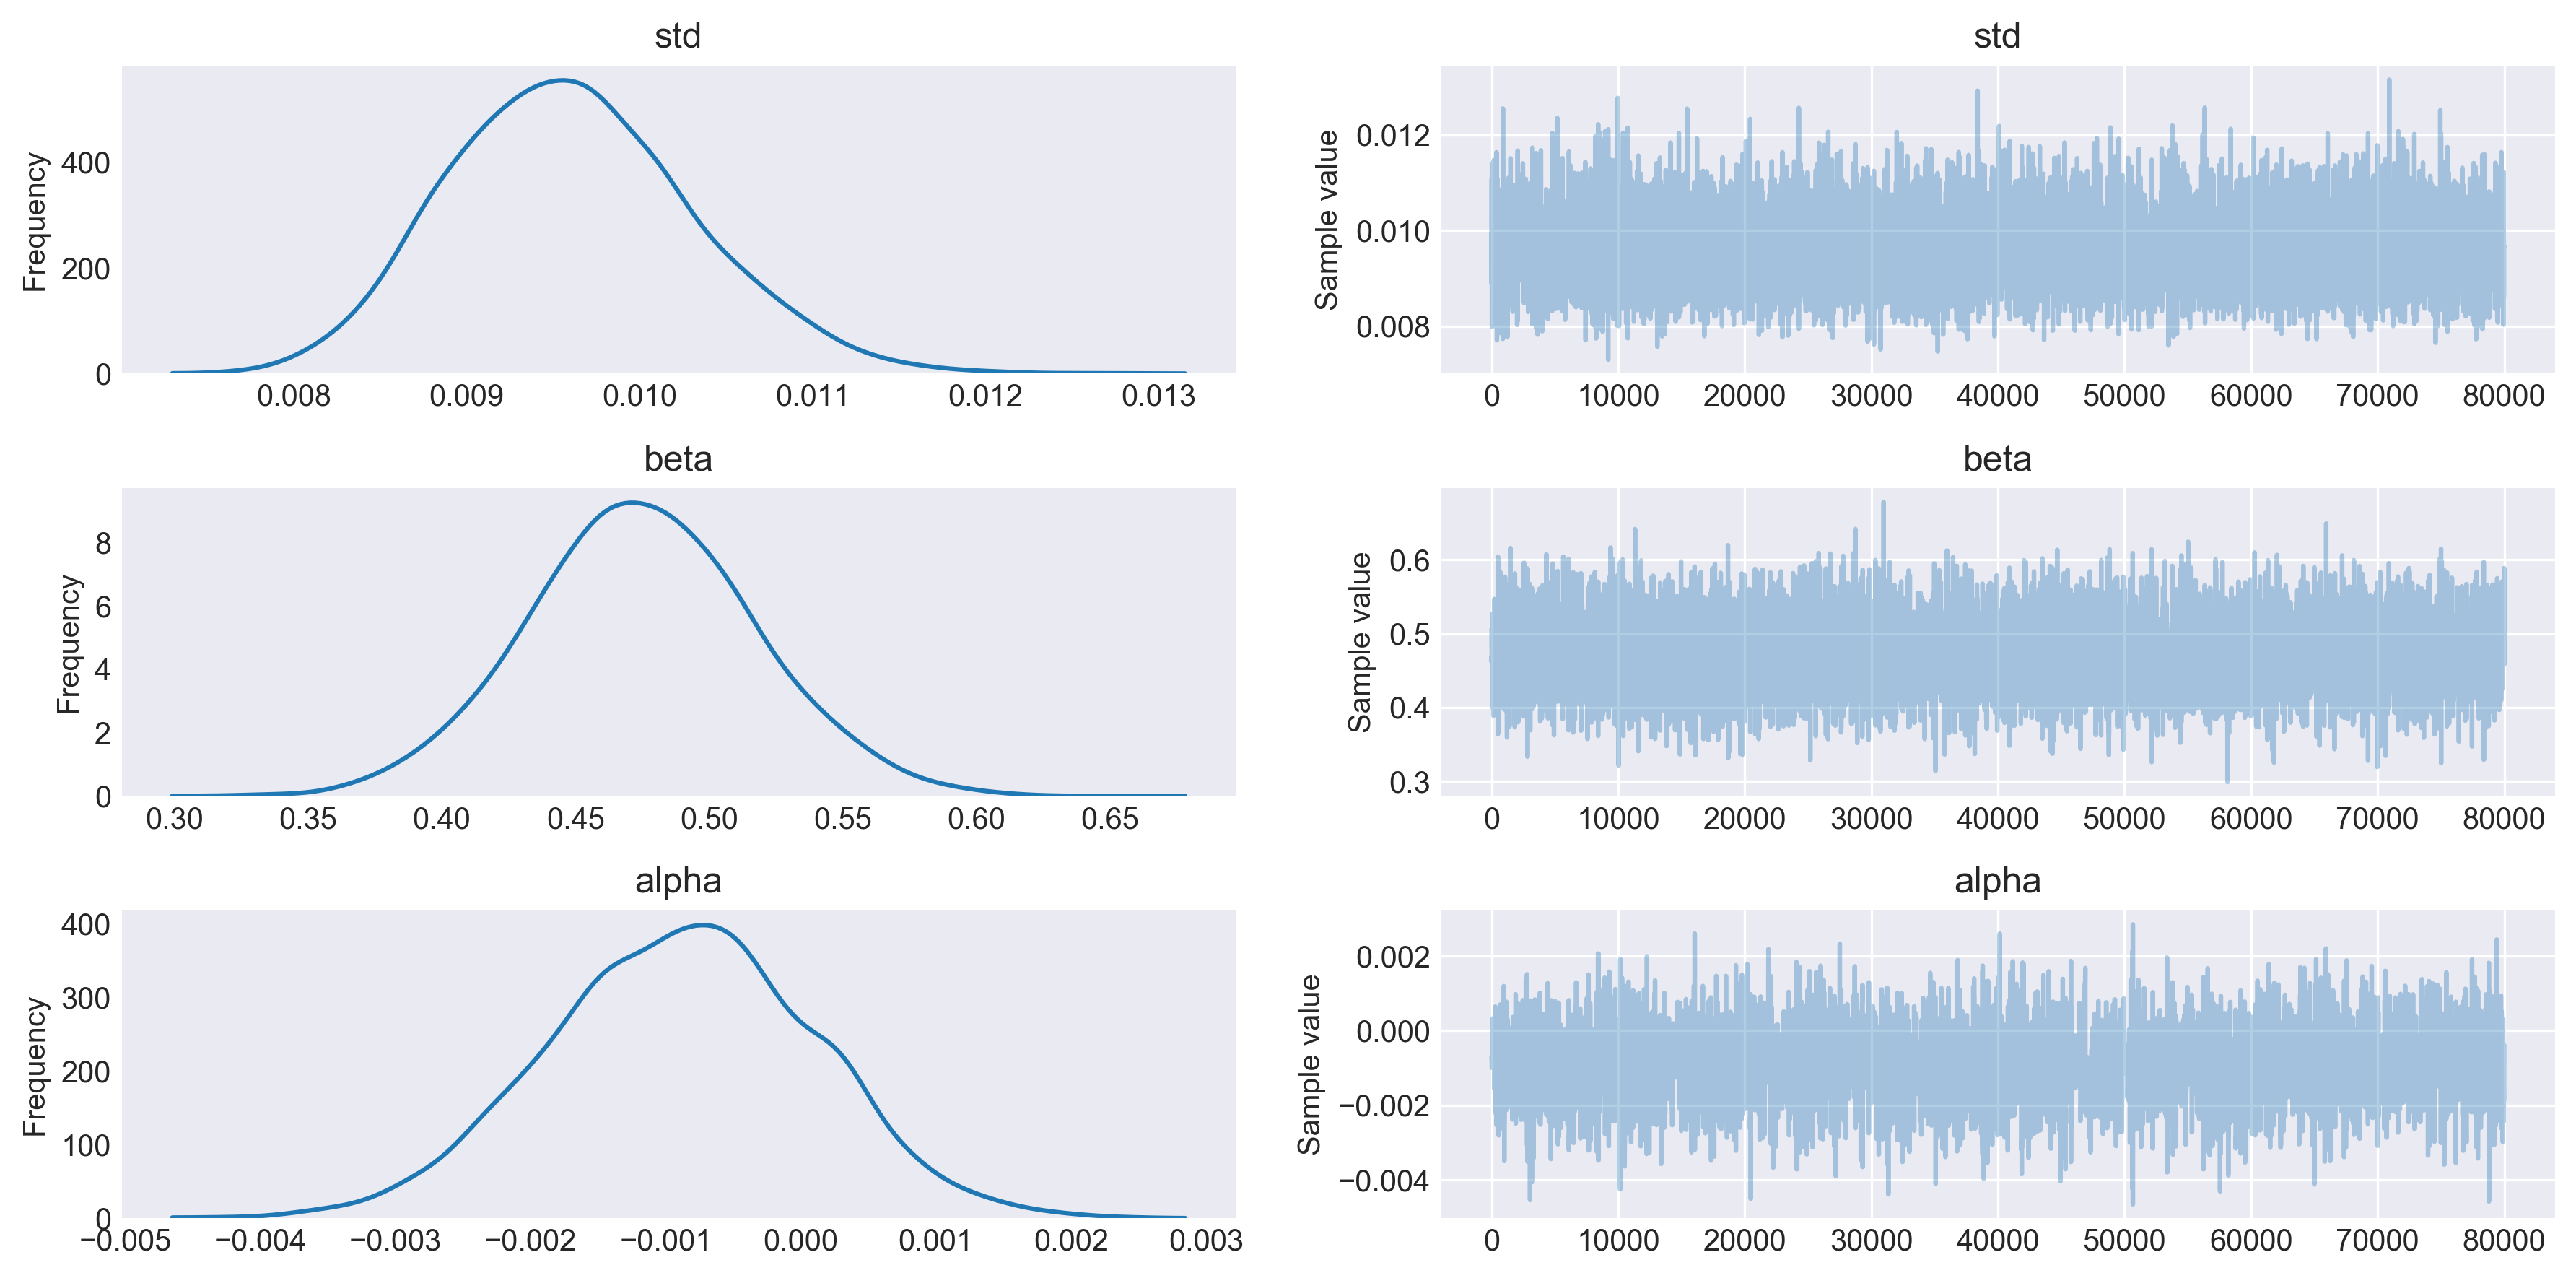

In [124]:
pm.plots.traceplot(trace=burned_trace, varnames=['std', 'beta', 'alpha'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c4a45bc18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c4a47c710>], dtype=object)

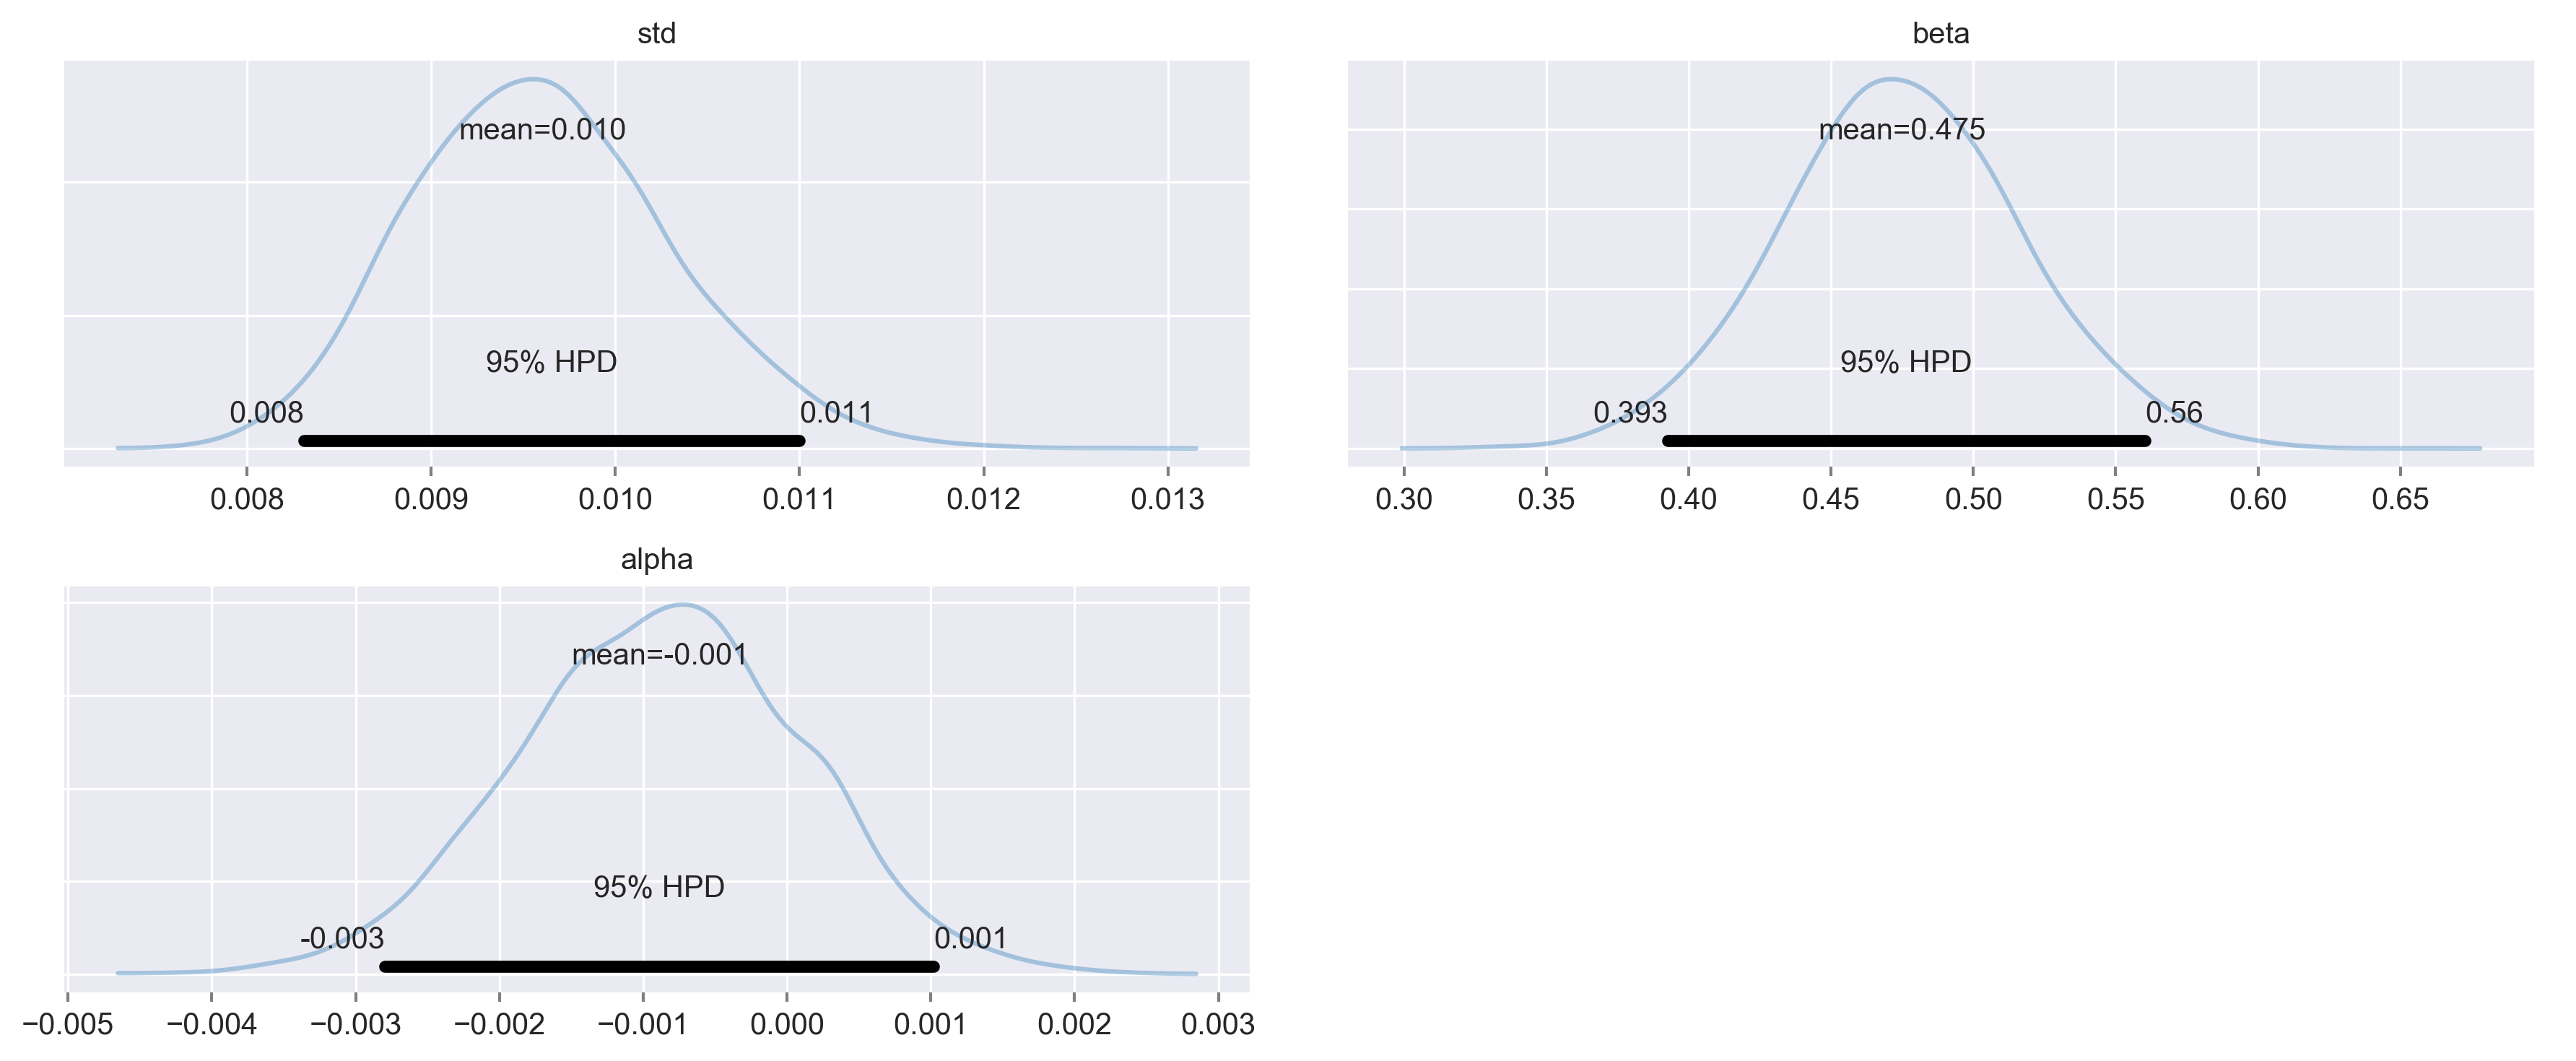

In [125]:
pm.plot_posterior(trace=burned_trace, varnames=['std', 'beta', 'alpha'], kde_plot=True)

- Bayesian actions over different trading signals.

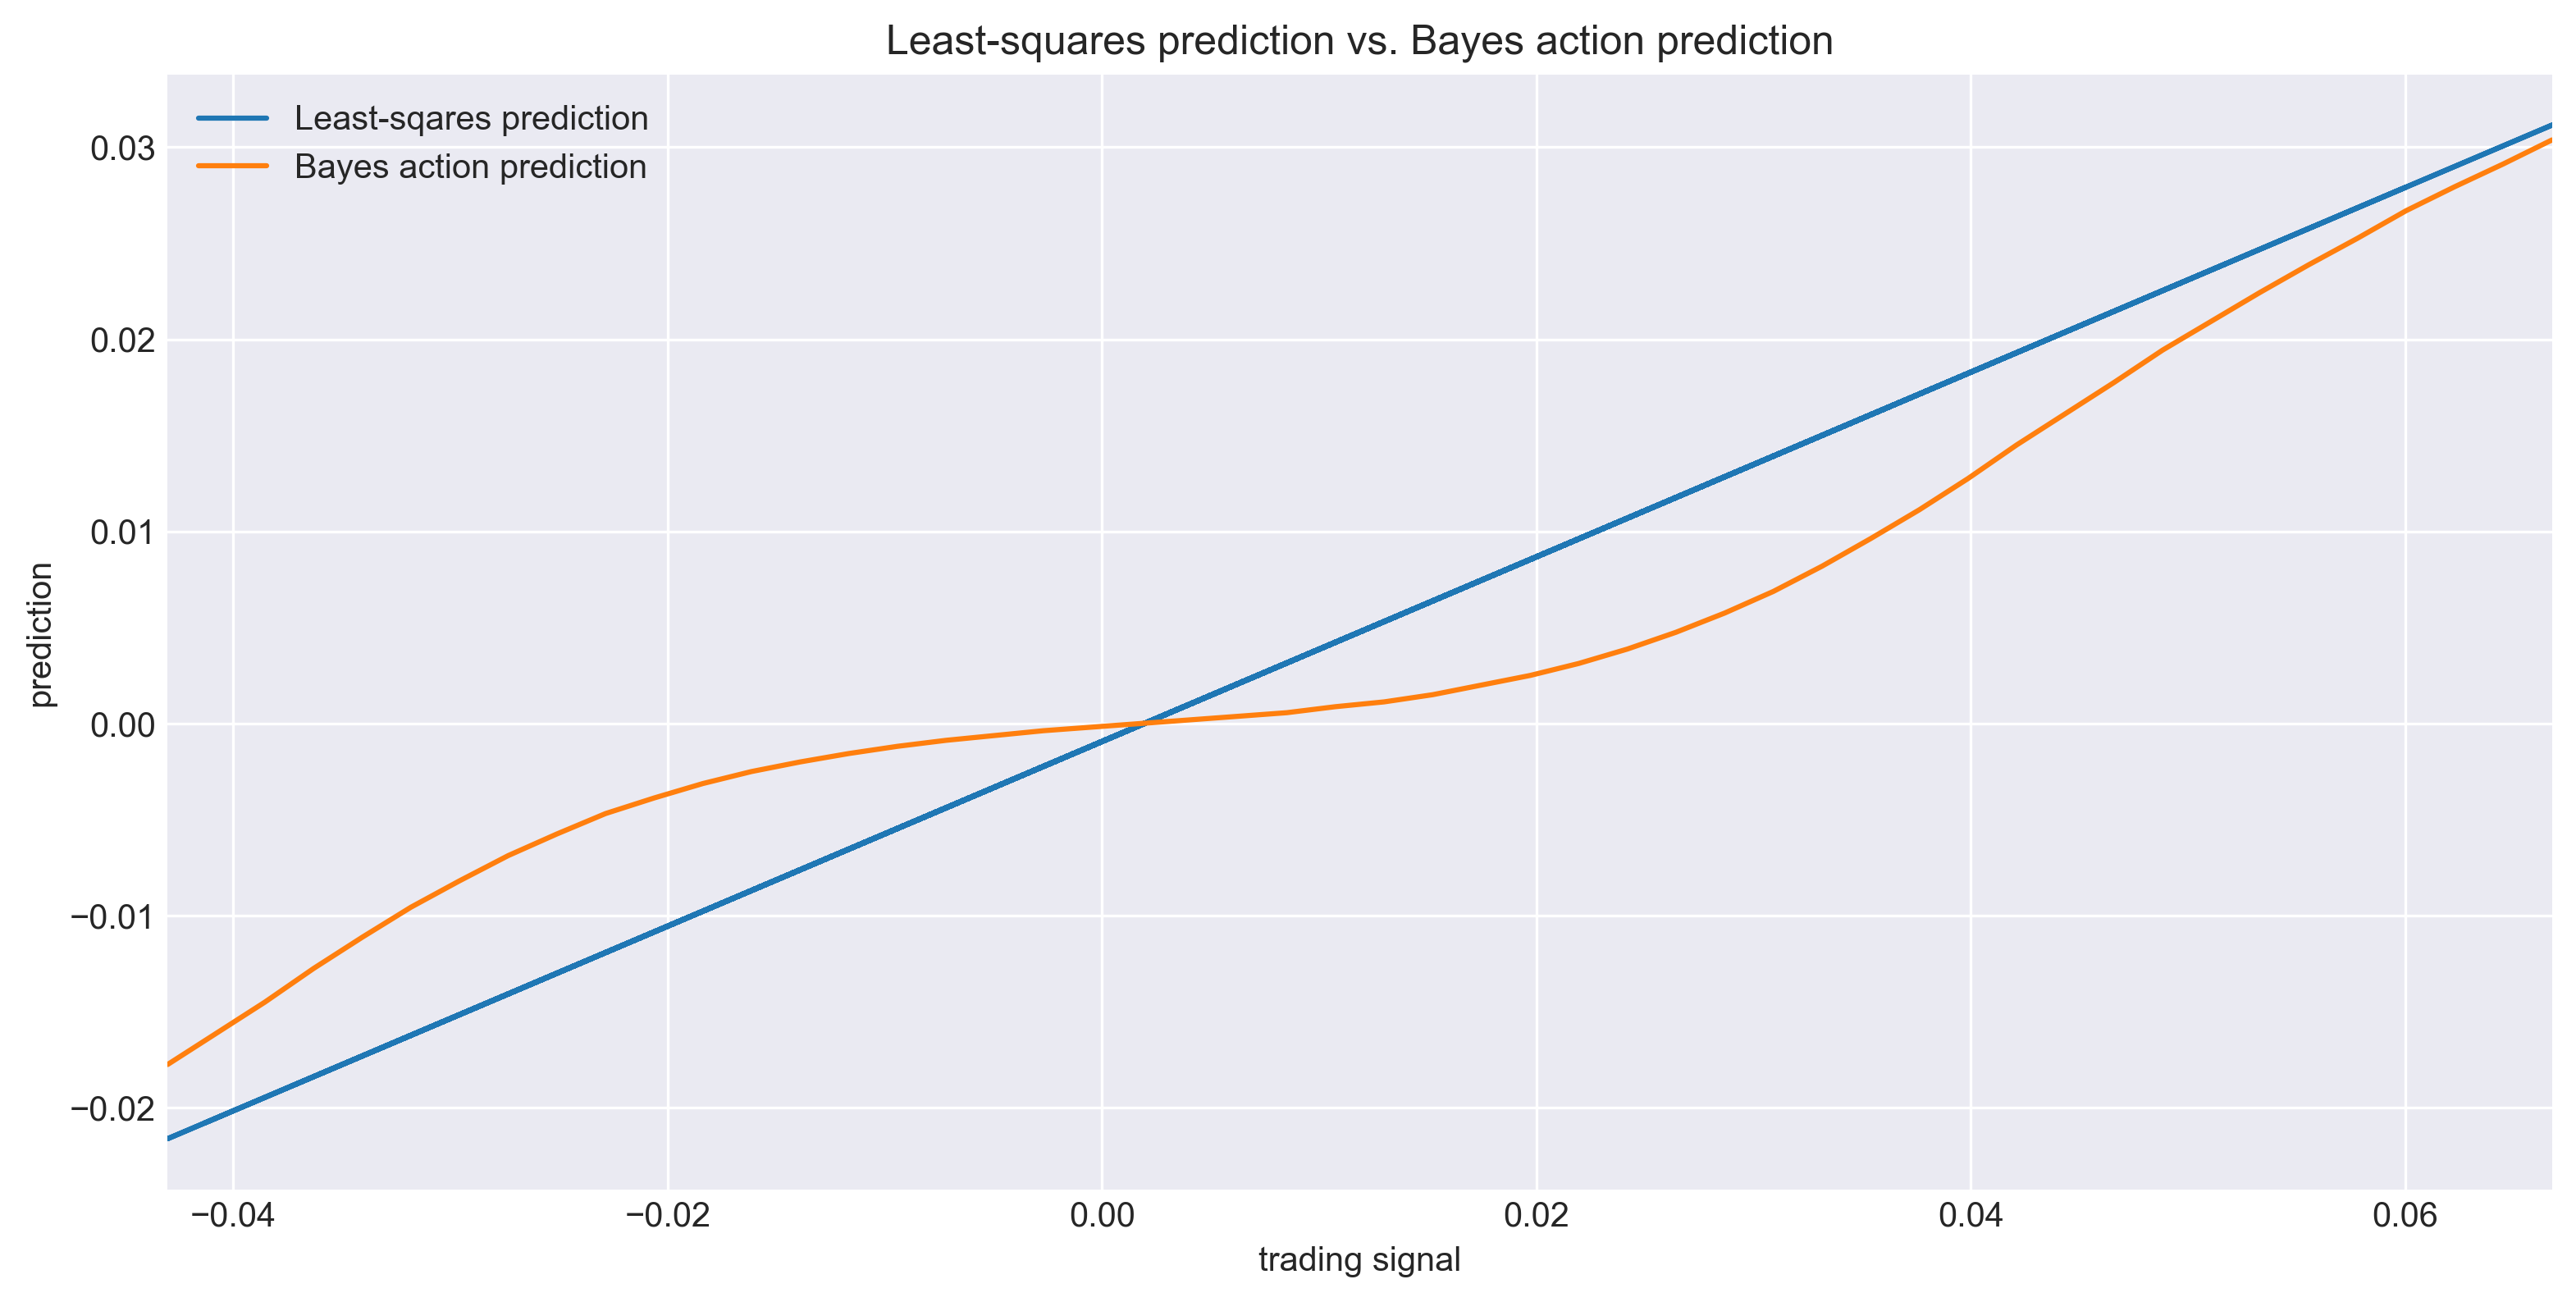

In [132]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    '''vectorized for numpy'''
    sol = np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    
    return sol
    
std_samples = burned_trace['std']
alpha_samples = burned_trace['alpha']
beta_samples = burned_trace['beta']

N = std_samples.shape[0]

noise = std_samples * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal + noise

opt_predictions = np.zeros(50)
trading_sginals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_sginals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)

plt.xlabel('trading signal')
plt.ylabel('prediction')
plt.title('Least-squares prediction vs. Bayes action prediction')
plt.plot(X, ls_coef_ * X + ls_intercept, label='Least-sqares prediction')
plt.plot(trading_sginals, opt_predictions, label='Bayes action prediction')
plt.xlim(X.min(), X.max())
plt.legend(loc='upper left')